In [1]:
import os; os.chdir("..")

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from urbanstats.games.quiz_analysis import get_full_statistics, questions
from urbanstats.games.quiz import display_question

/home/kavi/anaconda3/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [4]:
 plt.rcParams["font.family"] = "monospace"

In [5]:
result = get_full_statistics(after_problem=49, debug=False)
num_users_by_problem = result.groupby("problem").count().user_id
means = result[["problem", "score", *questions]].groupby("problem").mean()

/home/kavi/anaconda3/lib/python3.7/site-packages/pandas/core/groupby/groupby.py:1309: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  keys, values, mutated = self.grouper.apply(f, data, self.axis)


In [6]:
def line_histogram(offs, weights=None, dx=0.5):
    bin_sides = offs // dx * dx
    bins = np.arange(bin_sides.min(), bin_sides.max() + 1, dx)
#     plt.hist(offs, bins=bins, alpha=0.5, label=f"J{time}; total={offs.shape[0]}")
    y, be = np.histogram(offs, weights=weights, bins=bins)
    x = (be[1:] + be[:-1]) / 2
    return x, y

In [7]:
def plot():
    plt.figure(dpi=200, facecolor="white")
    for time in range(result.problem.max() - 2, result.problem.max() + 1):
        offs = result[(result.problem == time) & (result.last_in_batch == 1)].offset
        plt.plot(*line_histogram(offs), label=f"J{time}; total={offs.shape[0]}", lw=0.5)
    plt.xticks(rotation=90)
    plt.xlabel("Hours after EDT release")
    plt.ylabel("Frequency")
    lo, hi = plt.xlim()
    lo = lo // 4 * 4
    hi = hi // 4 * 4 + 4
    plt.xticks(np.arange(lo, hi + 4, 4))
    plt.grid()
    # plt.axvline(1.5, color="red", lw=0.5, label="Graph Crimes Post")
    # for h in 0, 1, 2, 3, 24, 25, 26, 27:
    #     plt.axvline(h, color="black", lw=0.5)
    plt.legend()
    plt.show()

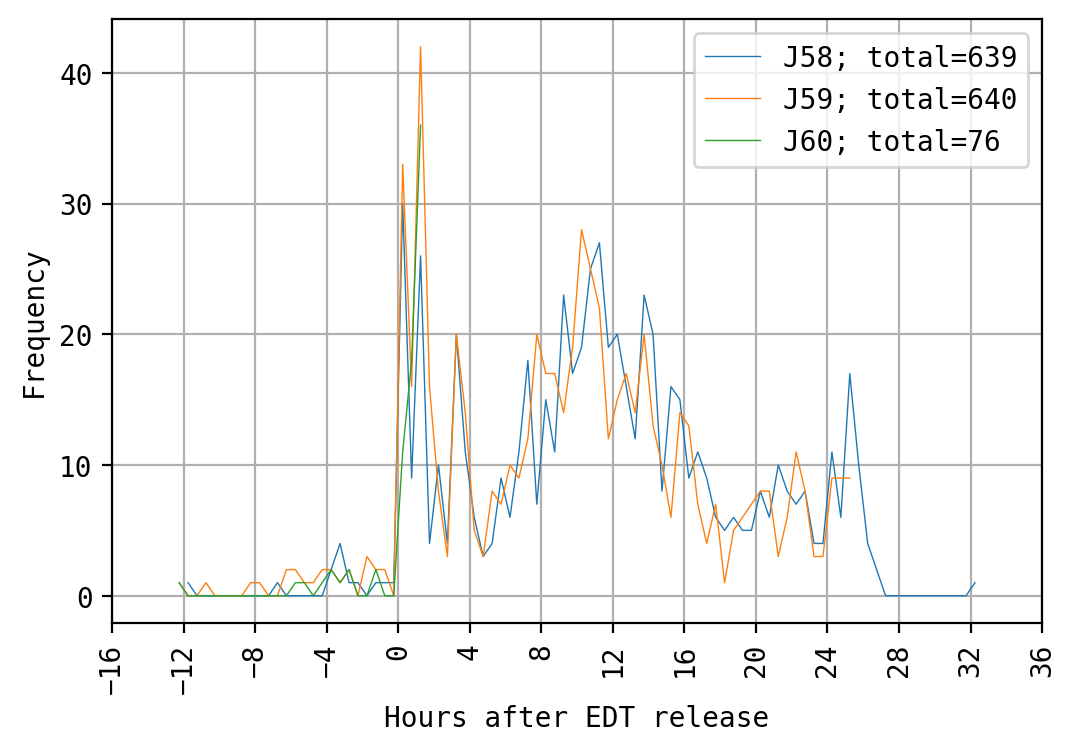

In [8]:
plot()

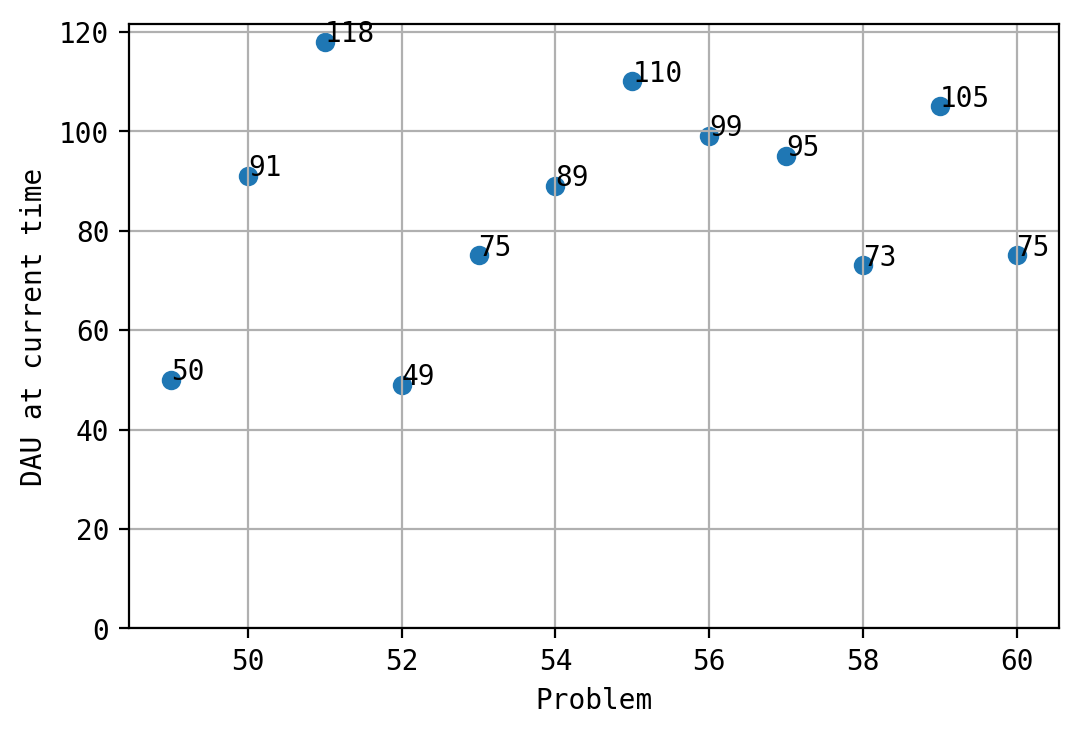

In [9]:
count_by_day = result[["problem", "last_in_batch"]].groupby("problem").sum().rename(columns={"last_in_batch": "c"})
today = count_by_day.index[count_by_day.c > 30].max()
time = result[result.problem == today].offset.max()
at_time = result[(result.offset < time) & (result.problem <= today)].groupby("problem").sum().last_in_batch
plt.figure(dpi=200)
plt.scatter(at_time.index, at_time)
for x in at_time.index:
    plt.text(s=int(at_time[x]), x=x, y=at_time[x])
plt.xlabel("Problem")
plt.ylabel("DAU at current time")
plt.ylim(0, plt.ylim()[1])
plt.grid()
plt.show()

In [10]:
def plot_juxtastat_times(compute_y, formatter=lambda x: f"{x:.0f}%", dx=0.5):
    plt.figure(dpi=200, facecolor="white")
    pre_today = result[(result.problem < today) & (result.last_in_batch == 1)].copy()
    time_all = pre_today.offset
    weights = 1 / pre_today.groupby("problem").count().user_id[pre_today.problem]
    weights /= weights.sum()
    pre_today['weight'] = list(weights)
    bins = np.arange(-14, 28 + dx, dx)
    y = []
    for xs, xe in zip(bins[:-1], bins[1:]):
        tab = pre_today[(xs <= pre_today.offset) & (pre_today.offset < xe)]
        y += [compute_y(tab)]
    x = (bins[1:] + bins[:-1]) / 2
    y = np.array(y)
    ymax = np.nanmax(y)
    # x, y = line_histogram(time_all, weights=100 * weights, dx=0.5)
    plt.plot(
        x, y,
        lw=0.5,
        marker=".",
        color="black"
    )
    plt.xlabel("Time in day [EDT]")
    plt.xticks([-12, -6, 0, 6, 12, 18, 24, 6])


    def span(s, e, color, name):
        plt.axvspan(s, e, alpha=0.5, color=color)
        count = compute_y(pre_today[(s <= time_all) & (time_all < e)])
        format_count = formatter(count)
        plt.text(x=(s + e) / 2, y=ymax * 1.1, s=f"{name}\n({format_count})", ha="center")


    span(-14, 0, "#f96d6d", "Non_US")
    span(0, 6, "#5a7dc3", "Night")
    span(6, 18, "#8ac35a", "Day")
    span(18, 28, "#4e525a", "Last Minute")

    plt.ylim(0, ymax * 1.3)
    plt.grid()

Text(0, 0.5, 'User concentration in this time [%]')

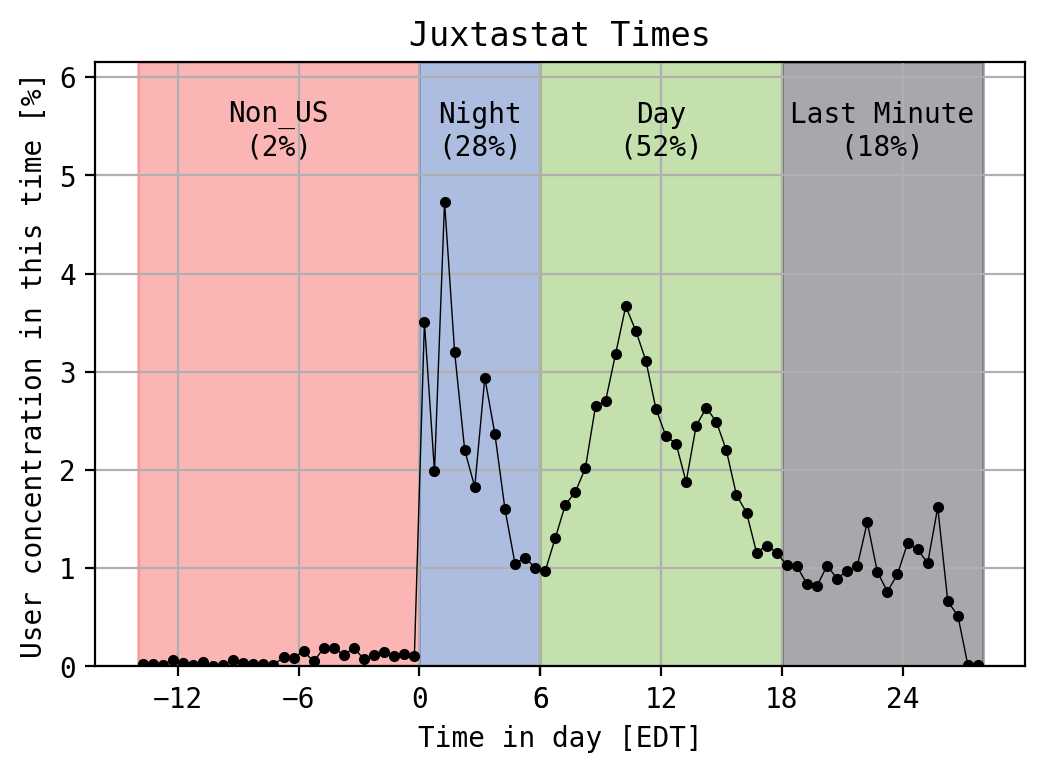

In [11]:
plot_juxtastat_times(compute_y=lambda tab: tab["weight"].sum() * 100)
plt.title("Juxtastat Times")
plt.ylabel("User concentration in this time [%]")

Text(0, 0.5, 'mean score this time')

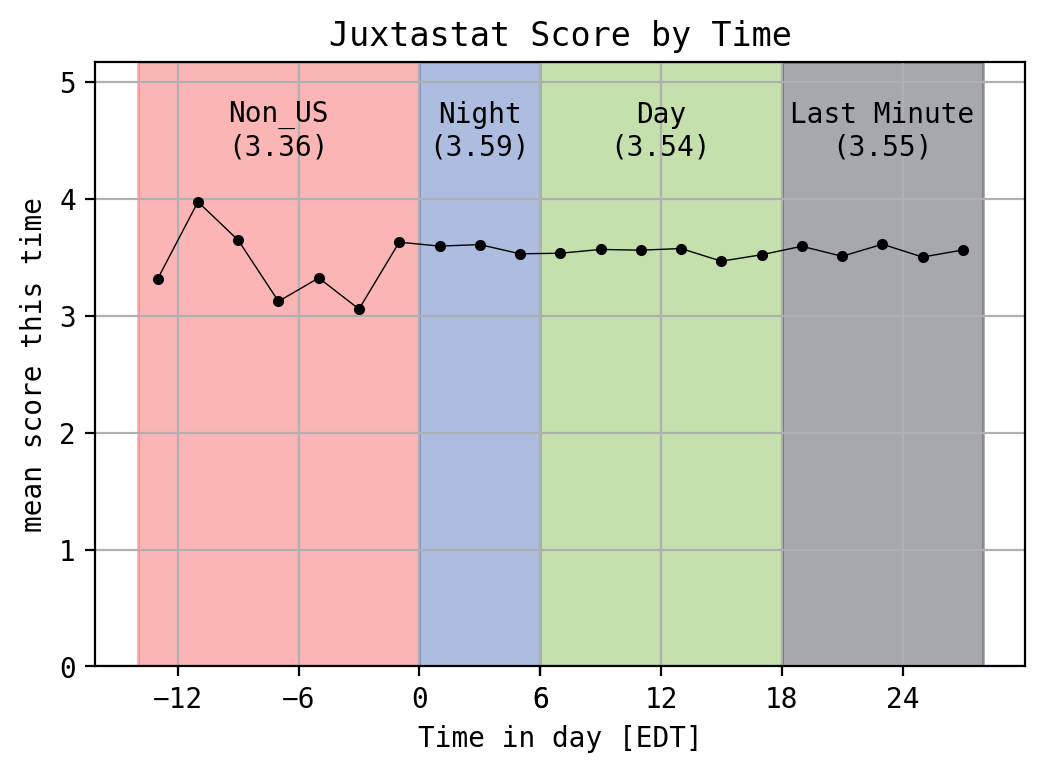

In [12]:
plot_juxtastat_times(
    compute_y=lambda tab: (tab["weight"] * tab["score"]).sum() / tab["weight"].sum()
    if tab["weight"].sum()
    else np.nan,
    formatter=lambda x: f"{x:.2f}",
    dx=2
)
plt.title("Juxtastat Score by Time")
plt.ylabel("mean score this time")

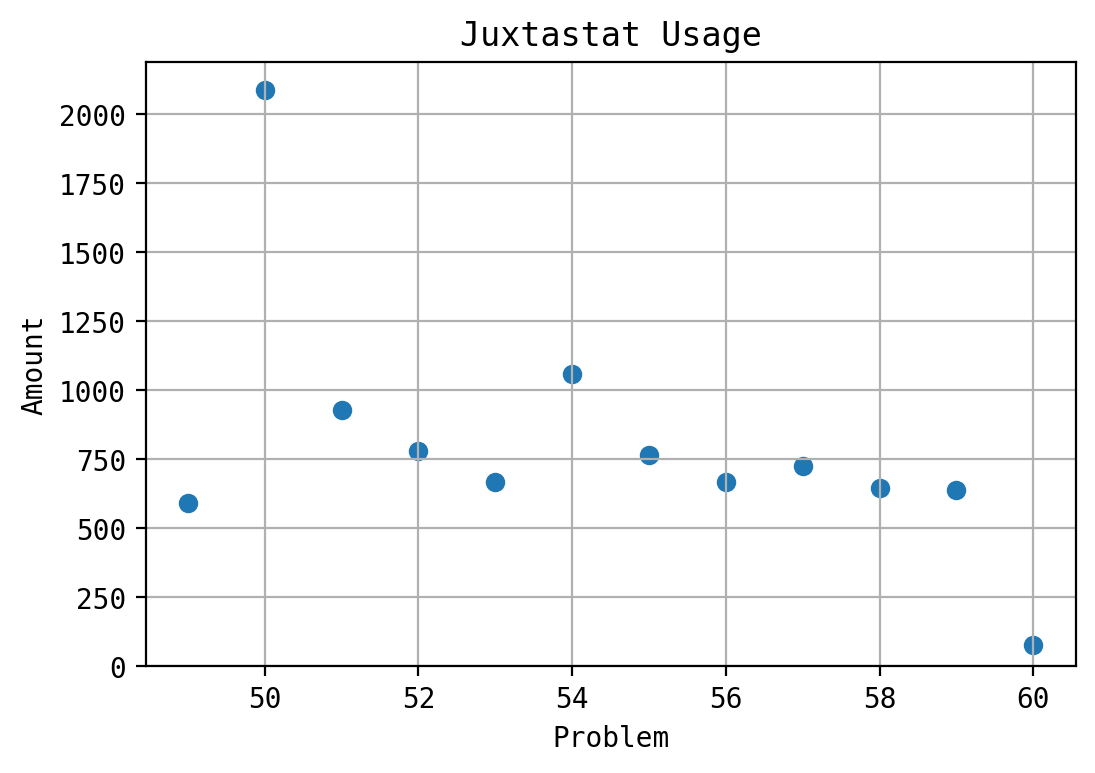

In [13]:
plt.figure(dpi=200)
plt.title("Juxtastat Usage")
plt.scatter(num_users_by_problem.index, num_users_by_problem)
plt.xlabel("Problem")
plt.ylabel("Amount")
plt.ylim(0, plt.ylim()[1])
plt.grid()

In [14]:
import sklearn.linear_model

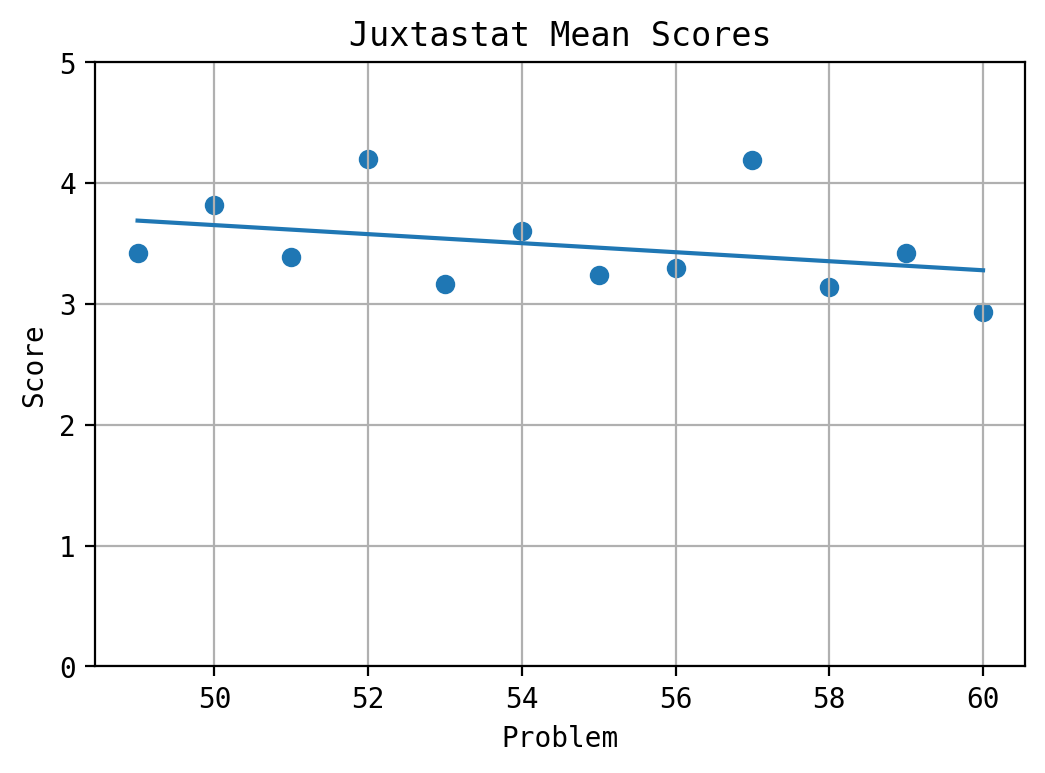

In [15]:
plt.figure(dpi=200, facecolor="white")
plt.title("Juxtastat Mean Scores")
plt.scatter(means.index, means.score)
lin = sklearn.linear_model.LinearRegression().fit(np.array(means.index)[:, None], means.score)
[m], b = lin.coef_, lin.intercept_
plt.plot(means.index, m * means.index + b)
plt.ylim(0, 5)
plt.xlabel("Problem")
plt.ylabel("Score")
plt.grid()

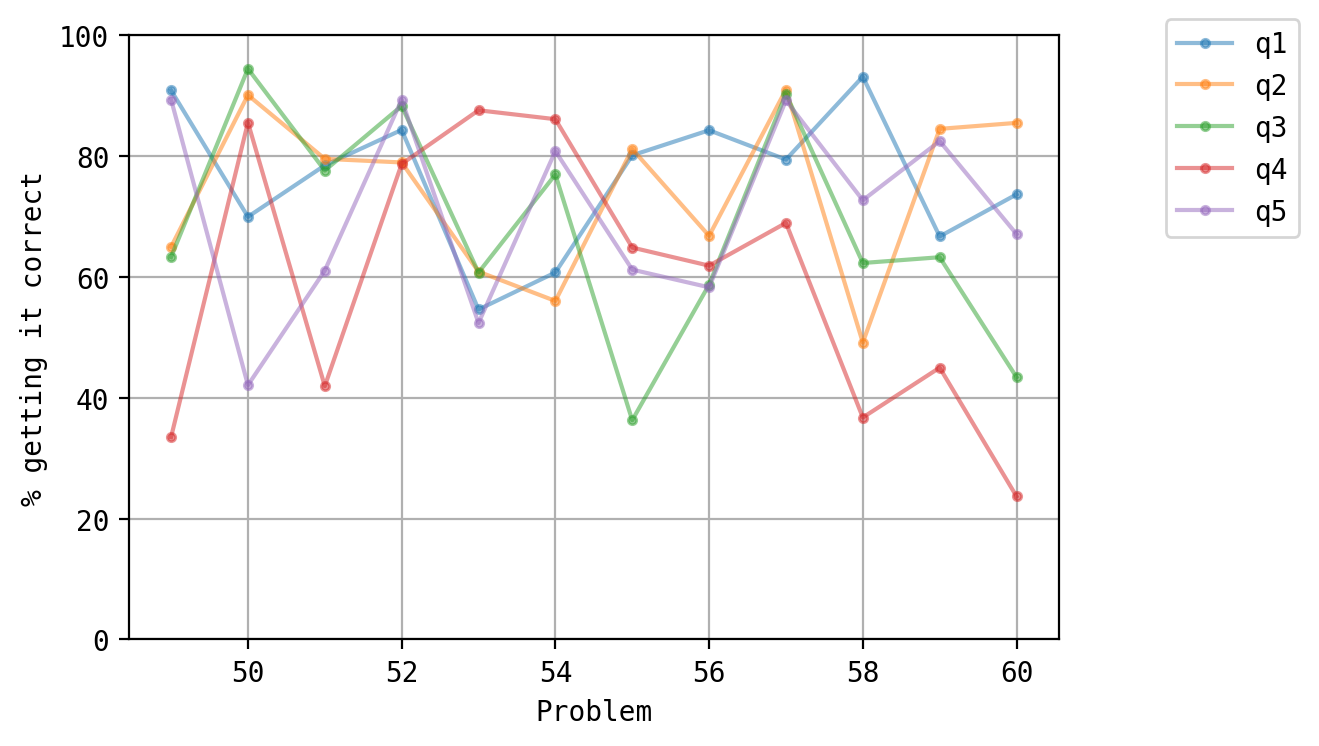

In [16]:
plt.figure(dpi=200)
for q in questions:
    plt.plot(means.index, 100 * means[q], label=q, marker=".", alpha=0.5)
plt.ylim(0, 100)
plt.xlabel("Problem")
plt.ylabel("% getting it correct")
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.grid()

In [17]:
from datetime import timedelta
import pandas as pd

In [18]:
flat_qs = pd.DataFrame(
    dict(
        correct=np.concatenate([means[question] for question in questions]),
        problem=np.concatenate([means[question].index for question in questions]),
        idx=np.concatenate(
            [
                np.zeros_like(means[question], dtype=np.long) + i
                for i, question in enumerate(questions)
            ]
        ),
    )
).sort_values("correct")
flat_qs["count"] = np.array(result.groupby("problem").count().user_id[flat_qs.problem])

In [19]:
def display_row(row):
    result = f"{row.correct:.0%} correct."
    result += f" Juxtastat {row.problem:.0f} q{row.idx + 1:.0f}\n"
    with open(f"/home/kavi/temp/site/quiz/{row.problem:.0f}") as f:
        q = json.load(f)[int(row.idx)]
    result += "  " + display_question(q["question"])
    result += "\n    a) " + q["longname_a"]
    result += "\n    b) " + q["longname_b"]
    return result

In [20]:
for i, (_, worst) in enumerate(flat_qs[:5].iterrows(), 1):
    print(f"{i}th worst performance: " + display_row(worst))

1th worst performance: 24% correct. Juxtastat 60 q4
  Which has a higher % of people who are Hispanic?
    a) Greeley MSA, CO, USA
    b) Denver-Aurora-Lakewood MSA, CO, USA
2th worst performance: 34% correct. Juxtastat 49 q4
  Which has less access to airports (higher population-weighted mean distance)?
    a) Davis County, Utah, USA
    b) Wake County, North Carolina, USA
3th worst performance: 36% correct. Juxtastat 55 q3
  Which has a higher % of residents who are non-citizens?
    a) Rutherford County, Tennessee, USA
    b) Pulaski County, Arkansas, USA
4th worst performance: 37% correct. Juxtastat 58 q4
  Which has a higher % of people who have commute time under 15 min?
    a) Amarillo TX Media Market, USA
    b) Tri-Cities TN-VA Media Market, USA
5th worst performance: 42% correct. Juxtastat 51 q4
  Which has a higher % of people who commute by walking?
    a) York County, South Carolina, USA
    b) St. Johns County, Florida, USA


In [21]:
for i, (_, worst) in enumerate(flat_qs[::-1][:5].iterrows(), 1):
    print(f"{i}th best performance: " + display_row(worst))

1th best performance: 94% correct. Juxtastat 50 q3
  Which has a higher population-weighted density (r=1km)?
    a) Minnesota, USA
    b) Rhode Island, USA
2th best performance: 93% correct. Juxtastat 58 q1
  Which has a higher % of people who have individual income over $100k?
    a) Puerto Rico, USA
    b) Maine, USA
3th best performance: 91% correct. Juxtastat 57 q2
  Which has a higher mean daily high temperature in winter (population weighted)?
    a) SD-00, USA
    b) OK-03, USA
4th best performance: 91% correct. Juxtastat 49 q1
  Which has a higher % of units with 2br rent over $1500?
    a) New Haven-Milford MSA, CT, USA
    b) South Bend-Mishawaka MSA, IN-MI, USA
5th best performance: 90% correct. Juxtastat 57 q3
  Which has less access to hospitals (higher population-weighted mean distance)?
    a) Montana, USA
    b) Florida, USA


In [22]:
result_time_relevant = result[result.last_in_batch == 1]

In [23]:
count_by_user_id = result_time_relevant.groupby("user_id").count().time
users = count_by_user_id.index[count_by_user_id > 5]

(array([4273.,  208.,  139.,   97.,   82.,   72.,   46.,   53.,   46.,
          57.]),
 array([ 1. ,  2.1,  3.2,  4.3,  5.4,  6.5,  7.6,  8.7,  9.8, 10.9, 12. ]),
 <BarContainer object of 10 artists>)

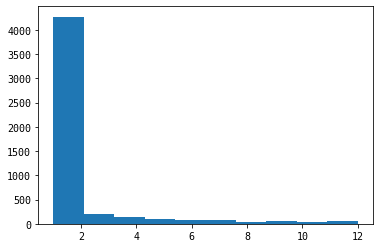

In [24]:
plt.hist(count_by_user_id)

In [25]:
def count_in_range(start, end):
    return result_time_relevant[
        (start < result_time_relevant.time)
        & (result_time_relevant.time < end)
    ].shape[0]

In [26]:
s = 10

In [27]:
by_user = {}
for user in users:
    before = after = 0
    for t in result_time_relevant[result_time_relevant.user_id == user].time:
        before += count_in_range(t - timedelta(minutes=s), t)
        after += count_in_range(t, t + timedelta(minutes=s))
    if after - before > 10:
        by_user[user] = after/before

In [28]:
by_ratio = pd.DataFrame(dict(ratio=by_user)).sort_values("ratio")[::-1]

In [29]:
vo = 1000233398257748901

result_time_relevant[result_time_relevant.user_id == vo]

,user_id,host,problem,pattern,time,last_in_batch,q1,q2,q3,q4,q5,score,date_challenge,offset
33,1000233398257748901,urbanstats.org,49,"[1, 1, 0, 1, 1]",2023-10-21 01:17:04.436000-04:00,1,1,1,0,1,1,4,2023-10-21 00:00:00-04:00,1.284566
584,1000233398257748901,urbanstats.org,50,"[0, 1, 1, 1, 0]",2023-10-22 01:24:37.492000-04:00,1,0,1,1,1,0,3,2023-10-22 00:00:00-04:00,1.410414
2633,1000233398257748901,urbanstats.org,51,"[1, 1, 1, 0, 1]",2023-10-23 01:01:13.499000064-04:00,1,1,1,1,0,1,4,2023-10-23 00:00:00-04:00,1.020416
3545,1000233398257748901,urbanstats.org,52,"[1, 1, 1, 1, 1]",2023-10-24 01:27:16.628999936-04:00,1,1,1,1,1,1,5,2023-10-24 00:00:00-04:00,1.454619
4362,1000233398257748901,urbanstats.org,53,"[1, 0, 1, 1, 1]",2023-10-25 01:35:55.167000064-04:00,1,1,0,1,1,1,4,2023-10-25 00:00:00-04:00,1.598658
5048,1000233398257748901,urbanstats.org,54,"[1, 1, 1, 1, 1]",2023-10-26 01:30:01.766000128-04:00,1,1,1,1,1,1,5,2023-10-26 00:00:00-04:00,1.500491
6079,1000233398257748901,urbanstats.org,55,"[1, 1, 0, 1, 1]",2023-10-27 01:10:47.423000064-04:00,1,1,1,0,1,1,4,2023-10-27 00:00:00-04:00,1.179840
6898,1000233398257748901,urbanstats.org,56,"[1, 1, 1, 0, 1]",2023-10-28 01:23:04.001999872-04:00,1,1,1,1,0,1,4,2023-10-28 00:00:00-04:00,1.384445
7620,1000233398257748901,urbanstats.org,57,"[1, 0, 1, 1, 1]",2023-10-29 02:26:26.889999872-04:00,1,1,0,1,1,1,4,2023-10-29 00:00:00-04:00,2.440803
8323,1000233398257748901,urbanstats.org,58,"[1, 0, 1, 1, 0]",2023-10-30 01:33:36.020999936-04:00,1,1,0,1,1,0,3,2023-10-30 00:00:00-04:00,1.560006
